In [3]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import scipy.stats as st
import matplotlib.pyplot as plt
import random

In [4]:
df = pd.read_csv("/home/divya/UBERT/CSV_files/Early_Exit_Confidence_data_yelp_max_exits(3,4,12)_difference.csv")
df.head(5)

,Unnamed: 0,Thi_layer_P,Fou_layer_P,Last_layer,PProb_thi,PProb_fou,PProb_las,True_labels
0,0,0,0,0,0.753920,0.800089,0.845397,0
1,1,0,1,1,0.594112,0.815985,0.813593,1
2,2,0,0,0,0.822457,0.724403,0.820971,0
3,3,0,0,0,0.743167,0.728612,0.674946,0
4,4,1,1,1,0.638572,0.865548,0.837171,1


In [77]:
# accuracy_imdb = []
# for j in df.columns:
#   accuracy = 0
#   for i in range(df.shape[0]):
#       if df[j][i] == df['True_labels'][i]:
#           accuracy += 1
#       else:
#           pass
#   print("Accuracy = ", accuracy/df.shape[0])
#   accuracy_imdb.append(accuracy)

In [78]:
number_of_actions = 10
action_set = [0.10*((i+10)/2) for i in range(number_of_actions)]
# action_set_1 = [0.10*((i+10)/3) for i in range(20)]
# action_set = []
# for i in range(len(action_set_1)):
#     if i%2 == 0:
#         action_set.append(action_set_1[i])

In [79]:
print((action_set))

[0.5, 0.55, 0.6000000000000001, 0.65, 0.7000000000000001, 0.75, 0.8, 0.8500000000000001, 0.9, 0.9500000000000001]


# One_UBERT_Cycle

In [80]:
def one_cycle(df, overhead):
    c_i_data = []
    for i in df["PProb_thi"]:
        c_i_data.append(i)
        
        
    c_l_data = []
    for i in df["PProb_las"]:
        c_l_data.append(i)
        
    number_of_actions = 10
    action_set = [0.10*((i+10)/2) for i in range(number_of_actions)]

    # action_set_1 = [0.10*((i+10)/3) for i in range(20)]
    # action_set = []
    # for i in range(len(action_set_1)):
    #     if i%2 == 0:
    #         action_set.append(action_set_1[i])
    
    
    def reward(c_i, c_l, action, overhead):
        if c_i >= action_set[action]:
            reward = 0
        else:
            reward = c_l - c_i - overhead
        return reward
    
    
    def next_action(Q, c_tilde, N, t):
      # Q is the list of rewards
      # c_tilde is the hyperparameter
      # N is the number of times an action is chosen
        next_a = []
        for i in range(len(action_set)):

            next_a.append(Q[i] + c_tilde*((np.log(t)/N[i])**(0.5)))

        return next_a.index(max(next_a))
    
    
    def update_parameters(Q, N, t, c_i_data, c_l_data, chosen_action, overhead):
        n = N[chosen_action]
        N[chosen_action] += 1
        Q[chosen_action] = (n*Q[chosen_action] + reward(c_i_data[t], c_l_data[t], chosen_action, overhead))/N[chosen_action]
        return Q, N
    
    

    def initialize(Q, N, action_set, c_i_data, c_l_data, overhead):
        for t in range(len(action_set)):
            update_parameters(Q, N, t, c_i_data, c_l_data, t, overhead)
        # print(N)
        return Q, N
    
    
    
    
    def oracle_action(overhead):
        oracle_reward = []
        for i in action_set:
            o_reward = 0 
            for t in range(df.shape[0]):
                if c_i_data[t] >= i:
                    reward = 0
    #                 predictions.append(df["Fou_layer_P"][t])
                else:
                    reward = c_l_data[t] - c_i_data[t] - overhead
                o_reward += reward
    #         print(oracle_reward)
            oracle_reward.append(o_reward/df.shape[0])

        return oracle_reward.index(max(oracle_reward)), oracle_reward
    oracle_action, o_reward = oracle_action(overhead)
    
    
    print("Oracle action =====> ", oracle_action)
    
    
    
    def one_UCB_cycle(Q, N, c_tilde, c_i_data, c_l_data, overhead, df):
        action_chosen = []
        predictions = []
        rewards = []
        count_1 = 0
        for t in range(df.shape[0]):
            if t < len(action_set):
                action = action_set[t]
                action_chosen.append(action)
                if c_i_data[t] >= action_set[t]:
                    reward = 0
                    predictions.append(df["Thi_layer_P"][t])
                    rewards.append(reward)
                else:
                    reward = c_l_data[t] - c_i_data[t] - overhead
                    predictions.append(df["Last_layer"][t])
                    rewards.append(reward)

            else:

                action = next_action(Q, c_tilde, N, t)
                # print(action)
                action_chosen.append(action)
                if c_i_data[t] >= action_set[action]:
                    reward = 0
                    predictions.append(df["Thi_layer_P"][t])
                    rewards.append(reward)
                    count_1+=1
                else:
                    reward = c_l_data[t] - c_i_data[t] - overhead
                    predictions.append(df["Last_layer"][t])
                    rewards.append(reward)
                Q, N = update_parameters(Q, N, t, c_i_data, c_l_data, action, overhead)

        return action_chosen, predictions, rewards, Q, N, count_1
    
    
    Q = [0 for i in range(len(action_set))]
    N = [0 for i in range(len(action_set))]
    c_tilde = 2
    Q, N = initialize(Q, N, action_set, c_i_data, c_l_data, overhead)
    action, preds, rewards, Q, N, count_1 = one_UCB_cycle(Q, N, c_tilde, c_i_data, c_l_data, overhead , df)
    
    optimal_action = Q.index(max(Q))
    print("Optimal_action index is ", optimal_action)
    print("Optimal_action is ", action_set[optimal_action])

    
    
    preds = []
    count = 0
    oracle_reward = []
    for i in range(df.shape[0]):
        
        if c_i_data[i] > action_set[oracle_action]:
            reward = 0
            count += 1
            preds.append(df["Thi_layer_P"][i])
            oracle_reward.append(reward)
        else:
            preds.append(df["Last_layer"][i])
            reward = c_l_data[i] - c_i_data[i] - overhead
            oracle_reward.append(reward)
                
    oracle_reward = np.array(oracle_reward)
    rewards = np.array(rewards)
    regret = (oracle_reward-rewards)
    cumulative_regret = abs(np.cumsum(regret))
    
    
    return cumulative_regret, count_1, action_set[optimal_action]

In [82]:
one_cycle(df, overhead = 0.1)

Oracle action =====>  3
Optimal_action index is  3
Optimal_action is  0.65


(array([0.00000000e+00, 1.19481200e-01, 1.19481200e-01, ...,
        5.01939620e+03, 5.01938272e+03, 5.01938272e+03]),
 359009,
 0.65)

In [83]:
idx = []
for i in range(df.shape[0]):
    if i%50 == 0:
        idx.append(i)

In [85]:
num_cycles = 5
reg_lis = []



for i in range(num_cycles):
    df = df.sample(frac = 1)
    cum_reg,_,_ = one_cycle(df, overhead = 0.1)


    reg_lis.append([cum_reg[j] for j in idx])
    
reg_lis = np.array(reg_lis)

Oracle action =====>  3
Optimal_action index is  3
Optimal_action is  0.65
Oracle action =====>  3
Optimal_action index is  3
Optimal_action is  0.65
Oracle action =====>  3
Optimal_action index is  3
Optimal_action is  0.65
Oracle action =====>  3
Optimal_action index is  3
Optimal_action is  0.65
Oracle action =====>  3
Optimal_action index is  3
Optimal_action is  0.65


In [86]:
len(reg_lis[0])

11200

In [87]:
lower = []
upper = []

for i in range(len(reg_lis[0])):

    intrval = st.t.interval(alpha=0.95, df=len(reg_lis[:,i])-1,
            loc=np.mean(reg_lis[:,i]),
            scale=st.sem(reg_lis[:,i]))
        
    lower.append(intrval[0])
    upper.append(intrval[1])

In [88]:
len(lower)

11200

# Other-Exit

In [89]:
def one_action_cycle(df, action):
    c_i_data = []
    for i in df["PProb_thi"]:
        c_i_data.append(i)
        
#     random.seed(9)    
    c_l_data = []
    for i in df["PProb_las"]:
        c_l_data.append(i)

    number_of_actions = 10
    action_set = [0.10*((i+10)/2) for i in range(number_of_actions)]
        
    # action_set_1 = [0.10*((i+10)/3) for i in range(20)]
    # action_set = []
    # for i in range(len(action_set_1)):
    #     if i%2 == 0:
    #         action_set.append(action_set_1[i])
    # print(action_set)
    overhead = 0.1
    
 
    def oracle_action(overhead):
        oracle_reward = []
        for i in action_set:
            o_reward = 0 
            for t in range(df.shape[0]):
                if c_i_data[t] >= i:
                    reward = 0
    #                 predictions.append(df["Fou_layer_P"][t])
                else:
                    reward = c_l_data[t] - c_i_data[t] - overhead
                o_reward += reward
    #         print(oracle_reward)
            oracle_reward.append(o_reward/df.shape[0])

        return oracle_reward.index(max(oracle_reward)), oracle_reward
    oracle_action, o_reward = oracle_action(overhead)
    
    
    print("Oracle action =====> ", oracle_action)
    
    
    preds = []
    count = 0
    oracle_reward = []
    for i in range(df.shape[0]):
        if c_i_data[i] > action_set[oracle_action]:
            reward = 0
            count += 1
            preds.append(df["Thi_layer_P"][i])
            oracle_reward.append(reward)
        else:
            preds.append(df["Last_layer"][i])
            reward = c_l_data[i] - c_i_data[i] - overhead
            oracle_reward.append(reward)
    
    
#     action = random.choice(action_set)
    print("Action is ", action)
    
    
    
     
    
    
    
    
#     preds = []
#     count_1 = 0
    rewards = []
    for i in range(df.shape[0]):
        
        if c_i_data[i] >= action:
            reward = 0
#                 count_1 += 1
            preds.append(df["Thi_layer_P"][i])
            rewards.append(reward)
        else:
            preds.append(df["Last_layer"][i])
            reward = c_l_data[i] - c_i_data[i] - overhead
            rewards.append(reward)
    
                
    oracle_reward = np.array(oracle_reward)
    rewards = np.array(rewards)
    regret = (oracle_reward-rewards)
    cumulative_regret = abs(np.cumsum(regret))
    # print(oracle_reward,'\n', rewards)
    
    
    return cumulative_regret

In [90]:
reg_lis_3 = []

for i in range(num_cycles):
    df = df.sample(frac = 1)
    cum_reg_3 = one_action_cycle(df, 0.5)  
    reg_lis_3.append([cum_reg_3[j] for j in idx])
    
reg_lis_3 = np.array(reg_lis_3)

Oracle action =====>  3
Action is  0.5
Oracle action =====>  3
Action is  0.5
Oracle action =====>  3
Action is  0.5
Oracle action =====>  3
Action is  0.5
Oracle action =====>  3
Action is  0.5


In [91]:
print(reg_lis_3)

[[0.00000000e+00 9.25095600e-01 2.11962086e+00 ... 1.40079633e+04
  1.40092877e+04 1.40094208e+04]
 [0.00000000e+00 9.82492250e-01 1.69764560e+00 ... 1.40070121e+04
  1.40081884e+04 1.40107701e+04]
 [0.00000000e+00 9.91435730e-01 1.91918224e+00 ... 1.40077233e+04
  1.40088233e+04 1.40107415e+04]
 [2.46849800e-01 2.10868168e+00 2.89116738e+00 ... 1.40056639e+04
  1.40082976e+04 1.40092355e+04]
 [8.81291700e-02 1.67579669e+00 3.52526165e+00 ... 1.40068822e+04
  1.40083820e+04 1.40103904e+04]]


In [92]:
lower_3 = []
upper_3 = []

for i in range(len(reg_lis[0])):
    intrval = st.t.interval(alpha=0.95, df=len(reg_lis_3[:,i])-1,
              loc=np.mean(reg_lis_3[:,i]),
              scale=st.sem(reg_lis_3[:,i]))

        
    lower_3.append(intrval[0])
    upper_3.append(intrval[1])

In [93]:
len(lower_3)

11200

# $\alpha = 0.8$

In [94]:
reg_lis_4 = []

for i in range(num_cycles):
    df = df.sample(frac = 1)
    cum_reg_4 = one_action_cycle(df, 0.8)

        
    reg_lis_4.append([cum_reg_4[j] for j in idx])
    
reg_lis_4 = np.array(reg_lis_4)

Oracle action =====>  3
Action is  0.8
Oracle action =====>  3
Action is  0.8
Oracle action =====>  3
Action is  0.8
Oracle action =====>  3
Action is  0.8
Oracle action =====>  3
Action is  0.8


In [95]:
print(reg_lis_4)

[[2.94200100e-01 3.06718998e+00 4.30406203e+00 ... 2.04080333e+04
  2.04101917e+04 2.04125854e+04]
 [1.91132400e-01 2.00936186e+00 3.17854202e+00 ... 2.04105238e+04
  2.04125000e+04 2.04133665e+04]
 [1.67968330e-01 4.59234930e-01 2.52331863e+00 ... 2.04092878e+04
  2.04114359e+04 2.04146931e+04]
 [0.00000000e+00 9.31902910e-01 2.88508771e+00 ... 2.04103444e+04
  2.04110006e+04 2.04130347e+04]
 [0.00000000e+00 6.00371340e-01 2.16089105e+00 ... 2.04097069e+04
  2.04112497e+04 2.04125327e+04]]


In [96]:
upper_4 = []
lower_4 = []

for i in range(len(reg_lis[0])):
    intrval = st.t.interval(alpha=0.95, df=len(reg_lis_4[:,i])-1,
              loc=np.mean(reg_lis_4[:,i]),
              scale=st.sem(reg_lis_4[:,i]))
        
    lower_4.append(intrval[0])
    upper_4.append(intrval[1])

# $\alpha = 0.9$  

In [97]:
reg_lis_5 = []
for i in range(num_cycles):
    df = df.sample(frac = 1)
    cum_reg_5 = one_action_cycle(df, 0.9)
        
    reg_lis_5.append([cum_reg_5[j] for j in idx])
    
reg_lis_5 = np.array(reg_lis_5)

Oracle action =====>  3
Action is  0.9
Oracle action =====>  3
Action is  0.9
Oracle action =====>  3
Action is  0.9
Oracle action =====>  3
Action is  0.9
Oracle action =====>  3
Action is  0.9


In [98]:
print(reg_lis_5)

[[3.49245600e-02 2.83035053e+00 6.32038041e+00 ... 3.49752681e+04
  3.49795373e+04 3.49835090e+04]
 [1.71007730e-01 1.71576578e+00 5.51035340e+00 ... 3.49771673e+04
  3.49800448e+04 3.49834344e+04]
 [0.00000000e+00 6.28305150e-01 5.01157167e+00 ... 3.49779396e+04
  3.49811266e+04 3.49844653e+04]
 [1.66737570e-01 3.19844236e+00 6.55470455e+00 ... 3.49781911e+04
  3.49814674e+04 3.49832392e+04]
 [5.53018000e-02 1.60666334e+00 5.31771385e+00 ... 3.49759533e+04
  3.49796483e+04 3.49836582e+04]]


In [99]:
lower_5 = []
upper_5 = []

for i in range(len(reg_lis[0])):
    intrval = st.t.interval(alpha=0.95, df=len(reg_lis_5[:,i])-1,
              loc=np.mean(reg_lis_5[:,i]),
              scale=st.sem(reg_lis_5[:,i]))
        
    lower_5.append(intrval[0])
    upper_5.append(intrval[1])

In [100]:
len(lower_5)

11200

# $Final-Exit$ 

In [101]:
reg_lis_fin = []
for i in range(num_cycles):
    df = df.sample(frac = 1)
    cum_reg_fin = one_action_cycle(df, 1.0)
        
    reg_lis_fin.append([cum_reg_fin[j] for j in idx])
    
reg_lis_fin = np.array(reg_lis_fin)

Oracle action =====>  3
Action is  1.0
Oracle action =====>  3
Action is  1.0
Oracle action =====>  3
Action is  1.0
Oracle action =====>  3
Action is  1.0
Oracle action =====>  3
Action is  1.0


In [102]:
print(reg_lis_fin)

[[2.61336860e-01 3.99862606e+00 8.45797483e+00 ... 3.55345675e+04
  3.55375277e+04 3.55414198e+04]
 [4.47090000e-03 1.56565671e+00 4.12873177e+00 ... 3.55330202e+04
  3.55378571e+04 3.55406192e+04]
 [0.00000000e+00 2.21462288e+00 5.77639585e+00 ... 3.55327354e+04
  3.55357174e+04 3.55396994e+04]
 [3.26384700e-01 2.76577073e+00 4.52750667e+00 ... 3.55344124e+04
  3.55377176e+04 3.55403665e+04]
 [3.38237400e-02 2.20079897e+00 3.79495119e+00 ... 3.55327611e+04
  3.55357268e+04 3.55408246e+04]]


In [103]:
lower_fin = []
upper_fin = []

for i in range(len(reg_lis[0])):
    intrval = st.t.interval(alpha=0.95, df=len(reg_lis_fin[:,i])-1,
              loc=np.mean(reg_lis_fin[:,i]),
              scale=st.sem(reg_lis_fin[:,i]))
        
    lower_fin.append(intrval[0])
    upper_fin.append(intrval[1])

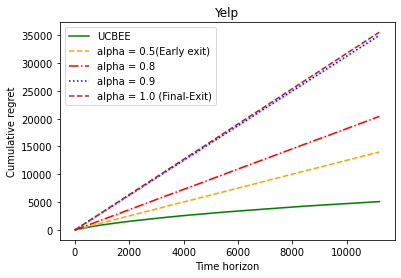

In [104]:
x = [i for i in range(len(idx))]
plt.plot(reg_lis.mean(axis = 0) ,'g', label="UCBEE",linestyle = 'solid')
plt.fill_between(x, lower, upper, color='green', alpha=0.1)
plt.plot(reg_lis_3.mean(axis = 0) ,'orange', label="alpha = 0.5(Early exit)", linestyle = 'dashed')
plt.fill_between(x, lower_3, upper_3, color='orange', alpha=0.1)
plt.plot(reg_lis_4.mean(axis = 0) ,'red', label="alpha = 0.8", linestyle = 'dashdot')
plt.fill_between(x, lower_4, upper_4, color='red', alpha=0.1)
plt.plot(reg_lis_5.mean(axis = 0) ,'blue', label="alpha = 0.9",linestyle = 'dotted')
plt.fill_between(x, lower_5, upper_5, color='blue', alpha=0.1)
plt.plot(reg_lis_fin.mean(axis = 0) ,'brown', label="alpha = 1.0 (Final-Exit)",linestyle = 'dashed')
plt.fill_between(x, lower_fin, upper_fin, color='brown', alpha=0.1)
plt.legend()
plt.xlabel("Time horizon")
plt.ylabel("Cumulative regret")
plt.title("Yelp")
plt.savefig('/home/divya/UBERT/Result_plot_new/Regret_plot_yelp_corrected.pdf')
plt.show()

In [105]:
# num_cycles = 5
def accuracy_lat_calcu(df, optimal_action, overhead = 0.1):
    c_i_data_thi = []
    for i in df["PProb_thi"]:
        c_i_data_thi.append(i)

    c_l_data = []
    for i in df["PProb_las"]:
        c_l_data.append(i)

    preds = []
    count_1 = 0
    for i in range(df.shape[0]):
        
        if c_i_data_thi[i] >= optimal_action:
            # reward = 0
            count_1+=1
#                 count_1 += 1
            preds.append(df["Thi_layer_P"][i])
        else:
            preds.append(df["Last_layer"][i])
            # reward = c_l_data[i] - c_i_data_thi[i] - overhead[0] - overhead[1]
            # rewards.append(reward)
    accuracy = 0
    for i in range(df.shape[0]):
        if preds[i] == df["True_labels"][i]:
            accuracy+=1
        else:
            pass
    return accuracy/df.shape[0], count_1/df.shape[0]

    

In [37]:
num_cycles = 5
accuracy_lis = []
latency_lis = []
for i in range(num_cycles):
    df = df.sample(frac = 1)
    _,_,optimal_action = one_cycle(df)
    accuracy, count_1 = accuracy_lat_calcu(df, optimal_action, overhead = 0.1)
    latency = count_1
    print("Optimal action is:", optimal_action,
          "\n=============================\n Fraction of Exits at intermediate layer",count_1,
          "\n=============================\n Total latency", 1-(count_1),
          "\n =====================\n Accuracy is", accuracy
              )
    accuracy_lis.append(accuracy)
    latency_lis.append(latency)
accuracy_lis = np.array(accuracy_lis)
latency_lis = np.array(latency_lis)

Oracle action =====>  2
Optimal_action index is  2
Optimal_action is  0.6000000000000001
Optimal action is: 0.6000000000000001 
 Fraction of Exits at intermediate layer 0.73416 
 Total latency 0.26583999999999997 
 Accuracy is 0.77128
Oracle action =====>  2
Optimal_action index is  2
Optimal_action is  0.6000000000000001
Optimal action is: 0.6000000000000001 
 Fraction of Exits at intermediate layer 0.73416 
 Total latency 0.26583999999999997 
 Accuracy is 0.76952
Oracle action =====>  2
Optimal_action index is  2
Optimal_action is  0.6000000000000001
Optimal action is: 0.6000000000000001 
 Fraction of Exits at intermediate layer 0.73416 
 Total latency 0.26583999999999997 
 Accuracy is 0.77016
Oracle action =====>  2
Optimal_action index is  2
Optimal_action is  0.6000000000000001
Optimal action is: 0.6000000000000001 
 Fraction of Exits at intermediate layer 0.73416 
 Total latency 0.26583999999999997 
 Accuracy is 0.77044
Oracle action =====>  2
Optimal_action index is  2
Optimal_a

In [40]:
print(np.mean(accuracy_lis))

0.7705359999999999


In [41]:
print(np.mean(latency_lis))

0.73416


In [106]:
overheads = [0, 0.05, 0.1, 0.15, 0.2]
acc_lis = []
exit_lis = []
for overhead in overheads:
    accuracy_lis = []
    e_lis = []
    for i in range(num_cycles):
        df = df.sample(frac = 1)
        _,_,optimal_action = one_cycle(df, overhead)
        accuracy, latency = accuracy_lat_calcu(df, optimal_action, overhead)
        accuracy_lis.append(accuracy)
        e_lis.append(latency)
    acc_lis.append(accuracy_lis)
    exit_lis.append(e_lis)
    
    

Oracle action =====>  5
Optimal_action index is  5
Optimal_action is  0.75
Oracle action =====>  5
Optimal_action index is  5
Optimal_action is  0.75
Oracle action =====>  5
Optimal_action index is  5
Optimal_action is  0.75
Oracle action =====>  5
Optimal_action index is  5
Optimal_action is  0.75
Oracle action =====>  5
Optimal_action index is  5
Optimal_action is  0.75
Oracle action =====>  4
Optimal_action index is  4
Optimal_action is  0.7000000000000001
Oracle action =====>  4
Optimal_action index is  4
Optimal_action is  0.7000000000000001
Oracle action =====>  4


In [ ]:
final_acc = []
for i in acc_lis:
    i = np.array(i)
    final_acc.append(np.mean(i))
print(final_acc)
    

[0.8259360000000001, 0.7864479999999999, 0.77004, 0.75864, 0.747]


In [ ]:
final_exit = []
for i in exit_lis:
    i = np.array(i)
    final_exit.append(np.mean(i))
print(final_exit)

[0.097576, 0.5580320000000001, 0.73416, 0.86976, 1.0]


In [ ]:
acc_lis_act = []
exit_lis_act = []
for action in action_set:
    accuracy_lis = []
    e_lis = []
    for i in range(num_cycles):
        df = df.sample(frac = 1)
        accuracy, latency = accuracy_lat_calcu(df, action, 0.1)
        accuracy_lis.append(accuracy)
        e_lis.append(latency)
    acc_lis_act.append(accuracy_lis)
    exit_lis_act.append(e_lis)

In [ ]:
final_acc_act = []
for i in acc_lis_act:
    i = np.array(i)
    final_acc_act.append(np.mean(i))
print(final_acc_act)

[0.747, 0.7589359999999999, 0.7701039999999999, 0.783, 0.797208, 0.811816, 0.8244480000000001, 0.8313280000000001, 0.8347600000000002, 0.835312]


In [ ]:
final_exit_act = []
for i in exit_lis_act:
    i = np.array(i)
    final_exit_act.append(np.mean(i))
print(final_exit_act)

[1.0, 0.86976, 0.73416, 0.59012, 0.42968, 0.26976, 0.12828, 0.04124, 0.00736, 0.00016]


In [ ]:
len(final_exit_act)

10

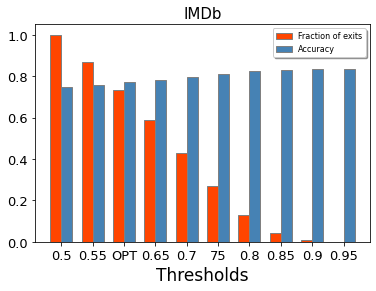

In [75]:
barWidth = 0.35
# fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
exit = final_exit_act
 
# Set position of bar on X axis
br1 = np.arange(len(exit))
br2 = [x + barWidth for x in br1]
# br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, exit, color ='orangered', width = barWidth,
        edgecolor ='grey', label ='Fraction of exits')
plt.bar(br2, final_acc_act, color ='steelblue', width = barWidth,
        edgecolor ='grey', label ='Accuracy')
# plt.bar(br3, accuracy_lis_1, color ='b', width = barWidth,
#         edgecolor ='grey', label ='CSE')
 
# Adding Xticks
plt.xlabel('Thresholds', fontsize = 17)
plt.ylabel('', fontweight ='bold', fontsize = 15)

plt.xticks([r + barWidth/2 for r in range(len(exit))],
        ['0.5', '0.55', '0.6', 'OPT', '0.7', '75', '0.8', '0.85', '0.9', '0.95'])



plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.title('Yelp', fontsize = 15)
 
plt.legend(['Fraction of exits', 'Accuracy'],
           prop = {'size' : 8},
           loc = 'upper right', shadow = True,
           facecolor = 'white')
plt.savefig('/home/divya/UBERT/Result_plot_new/UCBEE_Accuracy_vs_Thresholds_Yelp.pdf')
plt.show()